In [7]:
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
data = pd.read_csv('../data/transform/match_details_transformed.csv')

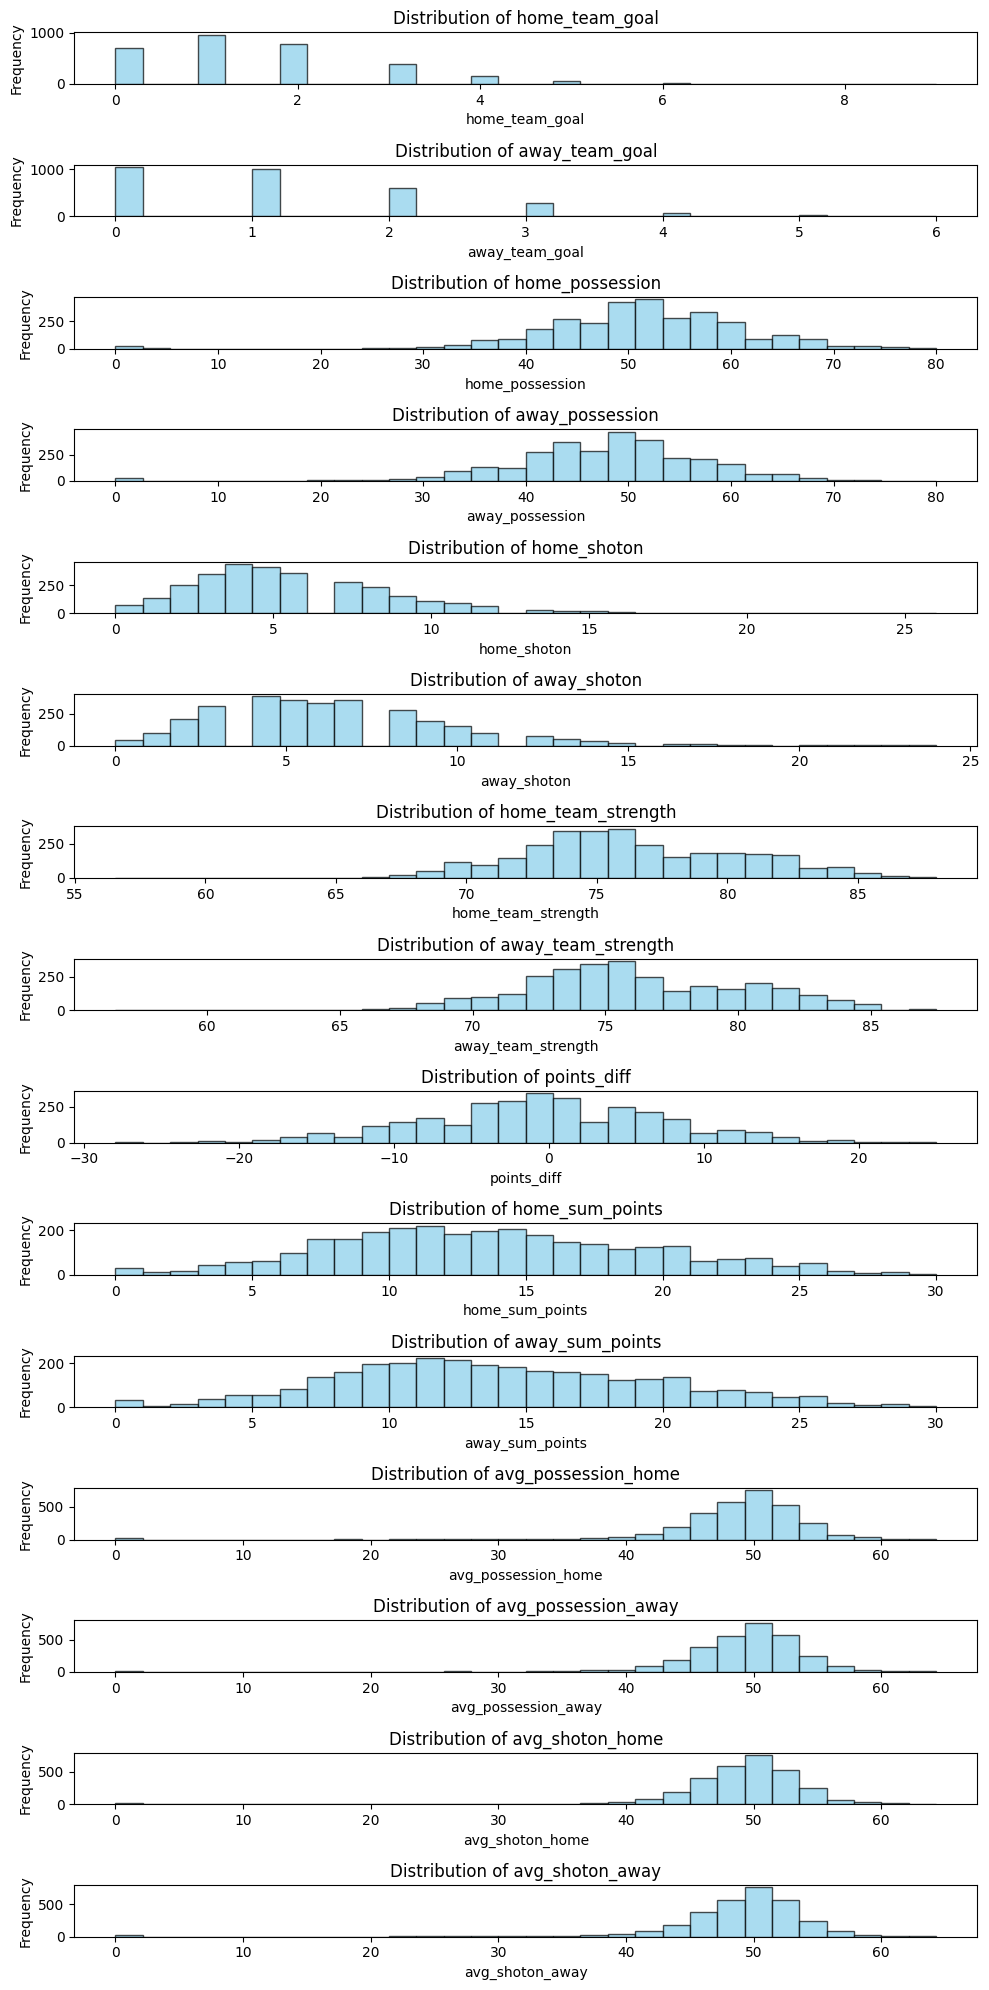

In [11]:
# Selected columns for EDA

selected_columns = [
    'home_possession', 'away_possession', 
    'home_shoton', 'away_shoton', 
    'home_team_strength', 'away_team_strength', 
    'points_diff', 'home_sum_points', 'away_sum_points',
    'avg_possession_home' ,'avg_possession_away'
    ,'avg_shoton_home' ,'avg_shoton_away'
]

# Setting up the figure
fig, axes = plt.subplots(nrows=len(selected_columns), ncols=1, figsize=(10, 20))

# Plotting the distribution for each column
for idx, col in enumerate(selected_columns):
    axes[idx].hist(data[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

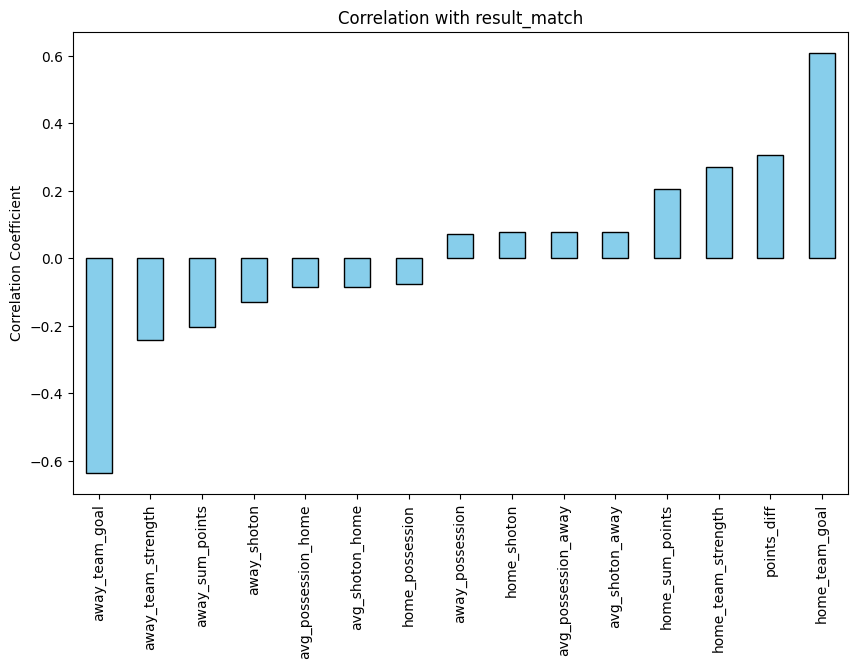

In [12]:
# Correlation of selected columns with 'result_match'
correlations = data[selected_columns + ['result_match']].corr()['result_match'].drop('result_match')

# Plotting the correlations
plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Correlation with result_match')
plt.ylabel('Correlation Coefficient')
plt.show()

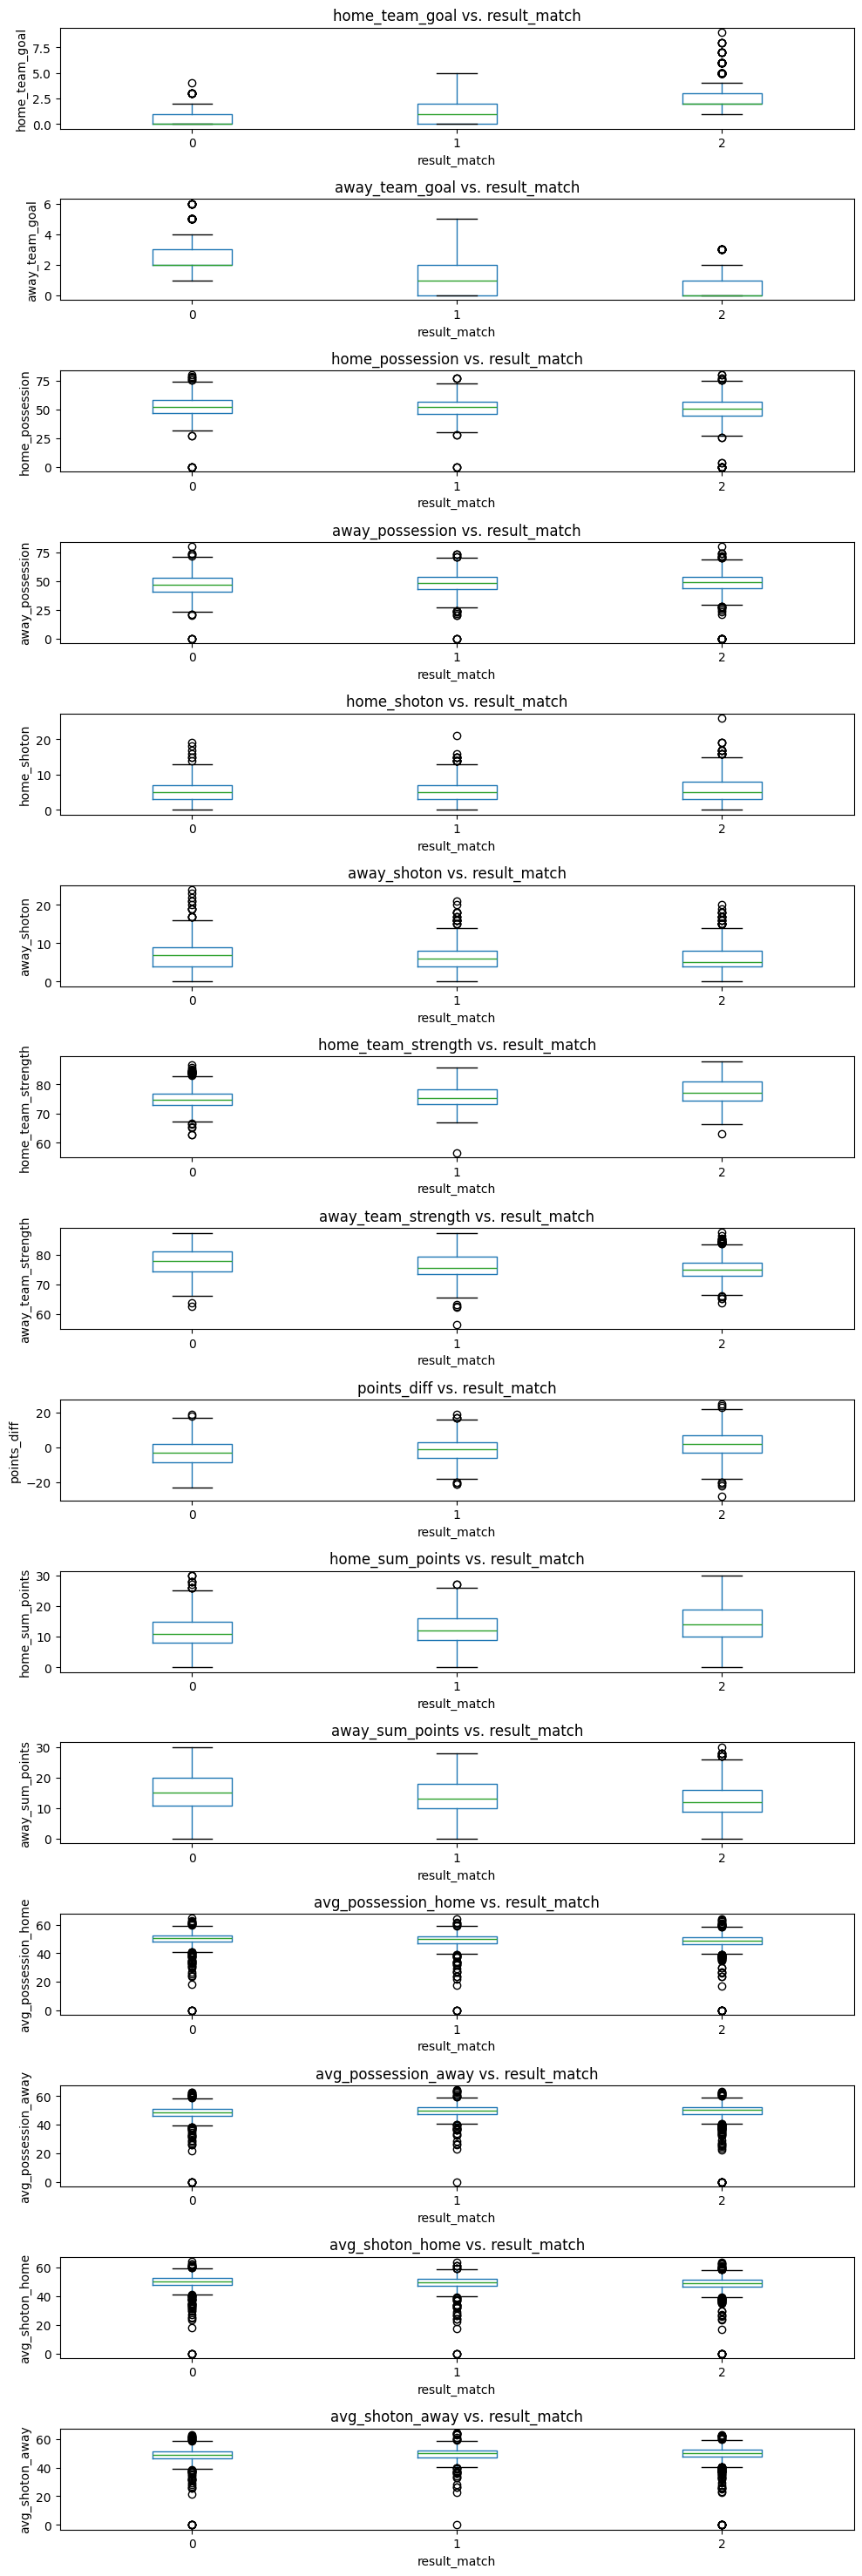

In [16]:
# Setting up the figure for boxplots
fig, axes = plt.subplots(nrows=len(selected_columns), ncols=1, figsize=(10, 30))

# Plotting boxplots for each column against 'result_match'
for idx, col in enumerate(selected_columns):
    data.boxplot(column=col, by='result_match', ax=axes[idx], grid=False)
    axes[idx].set_title(f'{col} vs. result_match')
    axes[idx].set_xlabel('result_match')
    axes[idx].set_ylabel(col)

# Adjusting layout and removing autogenerated title
plt.tight_layout()
plt.suptitle('')
plt.show()

In [ ]:

# home_avg_goals_scored
# away_avg_goals_scored
# home_avg_goals_conceded 
# away_avg_goals_conceded

# Creating the 'goal_difference' column
data['goal_difference'] = data['home_avg_goals_scored'] - data['away_avg_goals_scored']

# Plotting the distribution of 'goal_difference' for each match result
plt.figure(figsize=(10, 6))
for result in data['result_match'].unique():
    subset = data[data['result_match'] == result]
    plt.hist(subset['goal_difference'], bins=30, label=f'Result {result}', alpha=0.6)

plt.title('Distribution of Goal Difference by Match Result')
plt.xlabel('Goal Difference (Home - Away)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# 1. Match Outcome by Team Strength

# Creating a new column to indicate which team has higher strength
data['stronger_team'] = 'draw'
data.loc[data['home_team_strength'] > data['away_team_strength'], 'stronger_team'] = 'home'
data.loc[data['home_team_strength'] < data['away_team_strength'], 'stronger_team'] = 'away'

# Mapping result_match to outcomes
outcomes = {0: 'away_win', 1: 'draw', 2: 'home_win'}
data['match_outcome'] = data['result_match'].map(outcomes)

# Counting outcomes based on which team was stronger
strength_outcome = data.groupby(['stronger_team', 'match_outcome']).size().unstack()

strength_outcome.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcome by Team Strength')
plt.xlabel('Stronger Team')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Teams deemed "stronger" (either the home or away team) tend to win more often,
# as evidenced by the larger segments for "home_win" and "away_win" respectively.
strength_outcome

In [ ]:
# 2. Effect of Streaks

# Filtering matches where home or away teams are on a streak (considering 3 or more consecutive wins as a streak)
streak_threshold = 3
streak_data = data[data['home_streak_wins'] >= streak_threshold]

# Counting outcomes based on streaks
streak_outcomes = streak_data.groupby(['match_outcome']).size()

streak_outcomes

In [ ]:
streak_outcomes.plot(kind='pie', figsize=(8, 6), colormap='Set3', autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Match Outcomes when a home team is on a Streak')
plt.ylabel('')  # Removing the default ylabel
plt.tight_layout()
plt.show()

In [ ]:
# 3. Effect of Possession

# Creating bins for possession
bins = [0, 40, 50, 60, 100]
labels = ['<40%', '40-50%', '50-60%', '>60%']
data['possession_bins'] = pd.cut(data['home_possession'], bins=bins, labels=labels, right=False)

# Counting outcomes based on possession bins
possession_outcomes = data.groupby(['possession_bins', 'match_outcome']).size().unstack()

possession_outcomes

In [ ]:
# 3. Visualization for Effect of Possession

possession_outcomes.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcomes based on Home Team Possession')
plt.xlabel('Home Team Possession Percentage')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# 4. Feature Interactions

# Categorizing shots on target
data['high_shots_home'] = (data['home_shoton'] > data['home_shoton'].median()).astype(int)

# Counting outcomes based on high possession (>60%) and high shots on target (above median)
interaction_outcomes = data[data['home_possession'] > 60].groupby(['high_shots_home', 'match_outcome']).size().unstack()

interaction_outcomes

In [ ]:
# 4. Visualization for Feature Interactions

interaction_outcomes.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcomes based on High Possession and Shots on Target')
plt.xlabel('High Shots on Target (Above Median)')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()

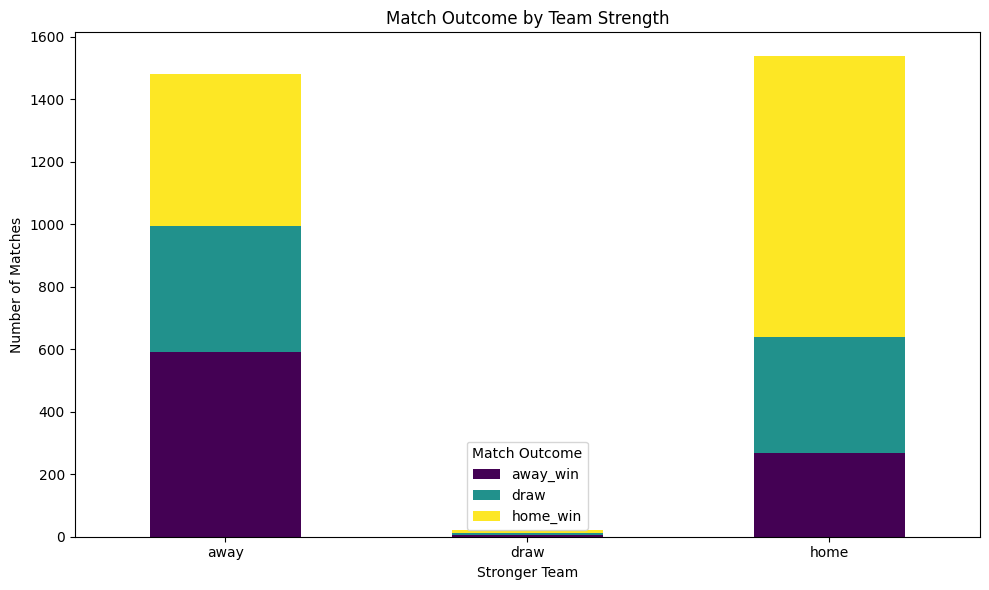

In [19]:
# 1. Match Outcome by Team Strength

# Creating a new column to indicate which team has higher strength
data['stronger_team'] = 'draw'
data.loc[data['home_team_strength'] > data['away_team_strength'], 'stronger_team'] = 'home'
data.loc[data['home_team_strength'] < data['away_team_strength'], 'stronger_team'] = 'away'

# Mapping result_match to outcomes
outcomes = {0: 'away_win', 1: 'draw', 2: 'home_win'}
data['match_outcome'] = data['result_match'].map(outcomes)

# Counting outcomes based on which team was stronger
strength_outcome = data.groupby(['stronger_team', 'match_outcome']).size().unstack()

strength_outcome.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcome by Team Strength')
plt.xlabel('Stronger Team')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
# Teams deemed "stronger" (either the home or away team) tend to win more often,
# as evidenced by the larger segments for "home_win" and "away_win" respectively.
strength_outcome

match_outcome,away_win,draw,home_win
stronger_team,,,
away,591,405,484
draw,7,6,9
home,269,372,897


In [37]:
# 2. Effect of Streaks

# Filtering matches where home or away teams are on a streak (considering 3 or more consecutive wins as a streak)
streak_threshold = 3
streak_data = data[data['home_streak_wins'] >= streak_threshold]

# Counting outcomes based on streaks
streak_outcomes = streak_data.groupby(['match_outcome']).size()

streak_outcomes

match_outcome
away_win     41
draw         28
home_win    121
dtype: int64

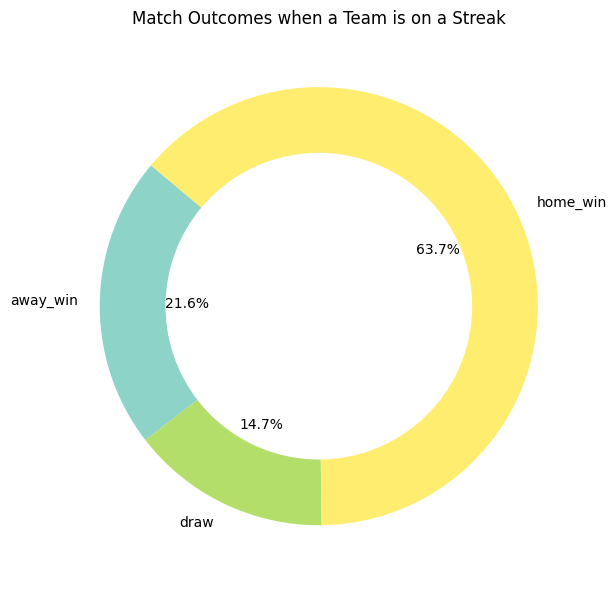

In [34]:
streak_outcomes.plot(kind='pie', figsize=(8, 6), colormap='Set3', autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Match Outcomes when a home team is on a Streak')
plt.ylabel('')  # Removing the default ylabel
plt.tight_layout()
plt.show()

In [38]:
# 3. Effect of Possession

# Creating bins for possession
bins = [0, 40, 50, 60, 100]
labels = ['<40%', '40-50%', '50-60%', '>60%']
data['possession_bins'] = pd.cut(data['home_possession'], bins=bins, labels=labels, right=False)

# Counting outcomes based on possession bins
possession_outcomes = data.groupby(['possession_bins', 'match_outcome']).size().unstack()

possession_outcomes

C:\Users\kamil\AppData\Local\Temp\ipykernel_6236\1327691340.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  possession_outcomes = data.groupby(['possession_bins', 'match_outcome']).size().unstack()


match_outcome,away_win,draw,home_win
possession_bins,,,
<40%,54,60,142
40-50%,269,245,444
50-60%,365,347,582
>60%,179,131,222


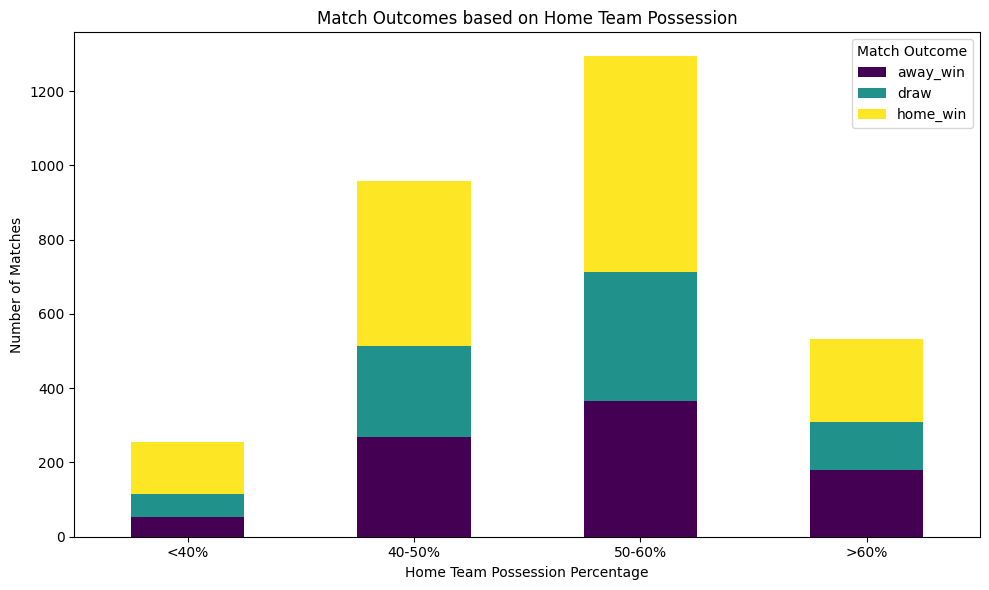

In [39]:
# 3. Visualization for Effect of Possession

possession_outcomes.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcomes based on Home Team Possession')
plt.xlabel('Home Team Possession Percentage')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:
# 4. Feature Interactions

# Categorizing shots on target
data['high_shots_home'] = (data['home_shoton'] > data['home_shoton'].median()).astype(int)

# Counting outcomes based on high possession (>60%) and high shots on target (above median)
interaction_outcomes = data[data['home_possession'] > 60].groupby(['high_shots_home', 'match_outcome']).size().unstack()

interaction_outcomes

match_outcome,away_win,draw,home_win
high_shots_home,,,
0,101,76,110
1,40,36,64


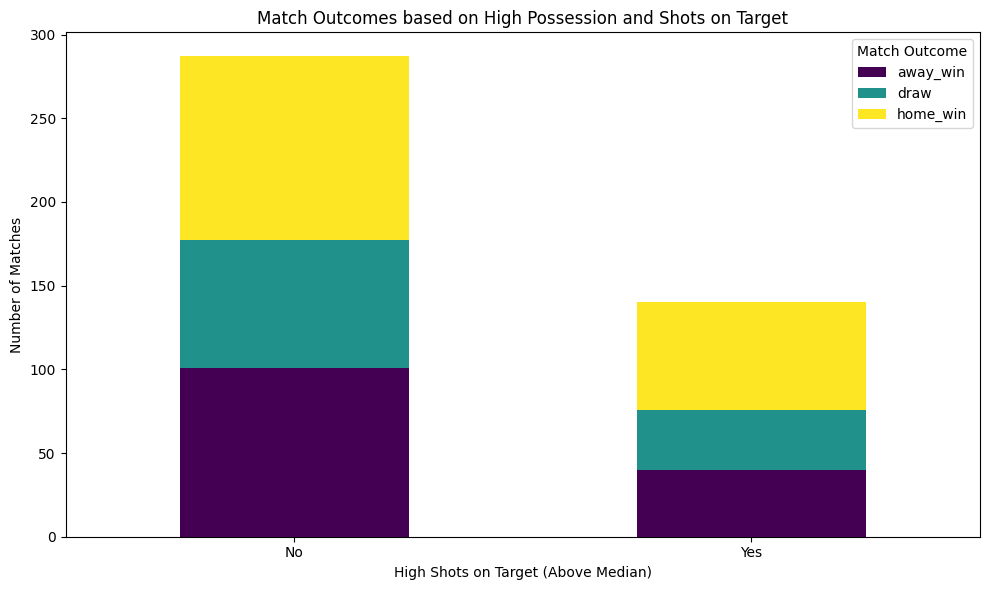

In [41]:
# 4. Visualization for Feature Interactions

interaction_outcomes.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcomes based on High Possession and Shots on Target')
plt.xlabel('High Shots on Target (Above Median)')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()